# DT2470 Lab 04: Shazam Wow!

by Bob L. T. Sturm

In this lab you will build and test a music fingerprinting system, similar to how Shazam does it – or at least as described in 2003: A. Wang, “An industrial strength audio search algorithm,” in Proc. Int. Soc. Music Info. Retrieval, Oct. 2003. Our approach is illustrated below. First we will take an audio signal and compute its time-frequency representation, or sonogram. Then we will strategically find several points of interest in that representation. For each of those points we will construct tuples using other points of interest in the sonogram. These will become hashes that describe the fingerprint of the audio signal.

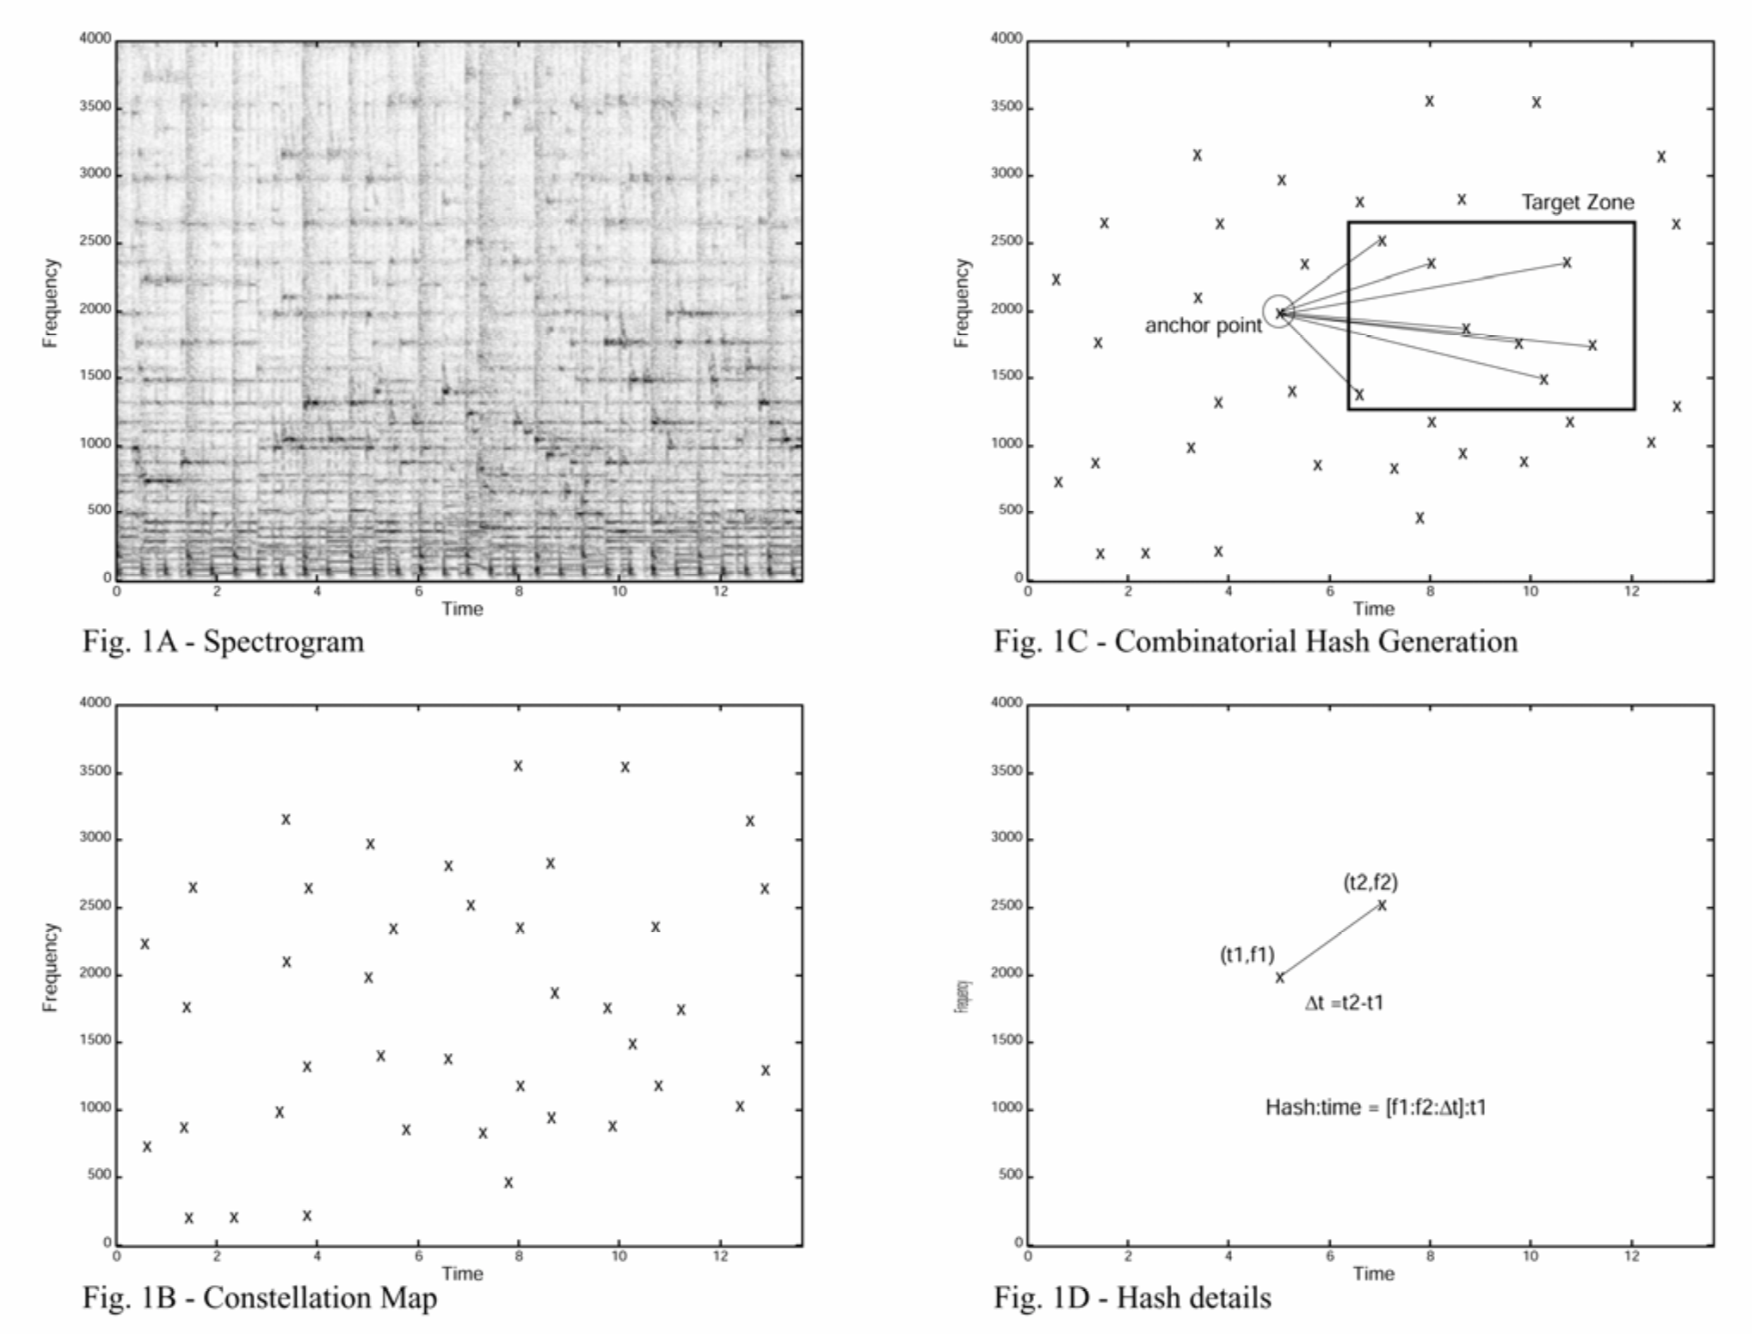

In the first part, you will gradually build said fingerprint creation system.

In the second part, you will build an algorithm that compares fingerprints.

The lab report you submit should be a testament to your intelligence, as well as a reflection of your willingness to be a part of this module. You are free to use whatever software you want, e.g., MATLAB, Processing, etc. But below I use python. See the first lab and its solutions for assistance.

I also include some images so you can confirm whether you are on the right track, or just to have a brief pause to laugh at how far your answer is from being correct.

## Preparations

In [3]:
import librosa
import os, sys
from scipy import signal
import pydub
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

QUERIES = '/home/leboucletoledo/Desktop/4/queries/'
KIKIBOUBA = '/home/leboucletoledo/Desktop/4/KikiBoubadata/'

In [10]:
class Query(object):

    def __init__(self, folder='', file_name='', frame_size_sec = 0.050, hop_size_sec = 0.010, zero_pad = 4):
        self.file_name = file_name
        self.folder = folder
        self.x = pydub.AudioSegment.from_file(self.folder + self.file_name, format='wav')
        self.sr = self.x.frame_rate
        self.x_arr = (np.array(self.x.get_array_of_samples()) / 2**16) * 2
        if self.x.channels ==2:
            channel_left = self.x_arr[::2]
            channel_right = self.x_arr[1::2]
            self.x_arr = channel_left
        self.time = np.linspace(0, len(self.x_arr) / (self.sr), num=len(self.x_arr))
        self.frame_size = int(frame_size_sec * self.sr)
        self.hop_size = int(hop_size_sec * self.sr)
        self.sr_nov = self.sr / self.hop_size
        self.zp = zero_pad
    
    def printAttributes(self):
        print('Duration of sample sound: ', self.x.duration_seconds)
        print('Sample rate of sample sound in Hz: ', self.sr)
        print('Number of channels: ', self.x.channels)

    def plotWaveform(self):
        plt.grid()
        plt.title('Original Waveform')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.plot(self.time, self.x_arr)
        # plt.ylim(-1, 1)
        
    def getSegment(self, start_time, duration_sec):

        stop_time = start_time + duration_sec
        start_time_idx = int(np.ceil(start_time * self.sr))
        stop_time_idx = int(np.ceil(stop_time * self.sr))

        seg_times = np.linspace(start_time, stop_time, int(np.ceil(self.sr * duration_sec)))
        seg = self.x_arr[start_time_idx:stop_time_idx]

        return seg_times, seg

    def STFT(self, array, plot=True):
        freq_axis, time_axis, stft = signal.stft(array, 
                                        fs=self.sr, 
                                        window='hann', 
                                        nfft=self.zp * self.frame_size, 
                                        nperseg=self.frame_size, 
                                        noverlap=(self.frame_size - self.hop_size)
                                        )    

        # Convert to KHz and get dB for STFT
        stft_magnitudes = np.abs(stft)
        stft_dB = librosa.amplitude_to_db(stft_magnitudes, ref=np.max)

        if plot==True:
            plt.figure()
            plt.title('dB STFT of {}; frame size={}, hop_size={}'.format(self.file_name, self.frame_size, self.hop_size))
            plt.xlabel('Time (s)')
            plt.xlim((0,self.x.duration_seconds))
            plt.ylabel('Frequency (KHz)')
            plt.ylim((0,5))
            plt.pcolormesh(time_axis, freq_axis / 1000, stft_dB, cmap='YlOrRd')
            plt.colorbar(format='%+2.0f dB')

        return stft_magnitudes, stft_dB, freq_axis, time_axis
    
    def getAnchors(self, stft, freqs, times, sr, num_bands=25, dTime=0.100):
        '''
        dTime: delta time in seconds
        sr: sample rate
        '''

        dFreq = (sr / 2) / num_bands
        num_timeSeg = int(np.floor(times[-1] / dTime))  
        anchors_magnitudes = np.empty((num_bands, num_timeSeg))
        anchors = []

        for f in range(num_bands):
            for t in range(num_timeSeg):
                freqSeg_idx = (freqs >= (f * dFreq)) & (freqs < ((f + 1) * dFreq))
                timeSeg_idx = (times >= (t * dTime)) & (times < ((t + 1) * dTime))
                freqSeg_idx = np.where(freqSeg_idx == True)[0]
                timeSeg_idx = np.where(timeSeg_idx == True)[0]

                # Get Lower and Upper bounds for frequency and time frames
                freqSeg_LL = freqSeg_idx[0]
                freqSeg_UL = freqSeg_idx[-1]
                timeSeg_LL = timeSeg_idx[0]
                timeSeg_UL = timeSeg_idx[-1]

                #  Frame the original STFT with bounds and find max value and indeces
                stft_frame = stft[freqSeg_LL:freqSeg_UL, timeSeg_LL:timeSeg_UL]
                anchors_magnitudes[f,t] = np.max(stft_frame)
                max_idx = np.unravel_index(np.argmax(stft_frame, axis=None), stft_frame.shape)
                freq_max_idx = freqSeg_idx[max_idx[0]]
                time_max_idx = timeSeg_idx[max_idx[1]]

                anchors.append([freqs[freq_max_idx], times[time_max_idx]])

        return np.array(anchors), anchors_magnitudes
    
    def getFingerprint(self, anchors):
        fingerprint = []
        num_anchors = anchors.shape[0]

        for anch in anchors:
            f1 = anch[0]
            t1 = anch[1]
            target_anchors = self.targetZone(f1, t1, anchors)

            for t_anch in target_anchors:
                f2 = t_anch[0]
                t2 = t_anch[1]
                dt = t2 - t1
                hsh = (f1, f2, dt)
                fingerprint.append([t1, hsh])

        return np.array(fingerprint, dtype=object)

    def targetZone(self, f1, t1, anchors, freq_range = 0.5):
    
        time_ll = 0.100
        time_ul = 0.500 + time_ll
        freq_zone = [2**(-freq_range), 2**(freq_range)]
        times_anchors = anchors[:,1]
        freqs_anchors = anchors[:,0]

        freq_targets = np.where(((f1 * freq_zone[0]) <= freqs_anchors) & ((f1 * freq_zone[1]) > freqs_anchors))[0]
        time_targets = np.where(((t1 + time_ll) <= times_anchors) & ((t1 + time_ul) > times_anchors))[0]
        targets_idx = np.intersect1d(freq_targets, time_targets)

        if len(targets_idx) == 0:
            return []

        return anchors[targets_idx]


# Part 1: Creating audio fingerprints

## 1.1 

Pick one of the query sound files and compute its dB magnitude short-time Fourier transform using a Hann window of duration 50 ms with a window hopsize of 10 ms, and zeropadding to four times the length of the window. Plot said sonogram, and appropriately label your axes with "Frequency (kHz)" and "Time (s)". The frequency axis must be in kiloHertz, and limited 0 to 5000 Hz. The time axis must be in seconds. Choose a colormap that you feel describes your personality (https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html).


In [11]:
q5 = Query(folder=QUERIES, file_name='Q5.wav', frame_size_sec=0.050, hop_size_sec=0.010, zero_pad=4)

Duration of sample sound:  10.231451247165532
Sample rate of sample sound in Hz:  44100
Number of channels:  1


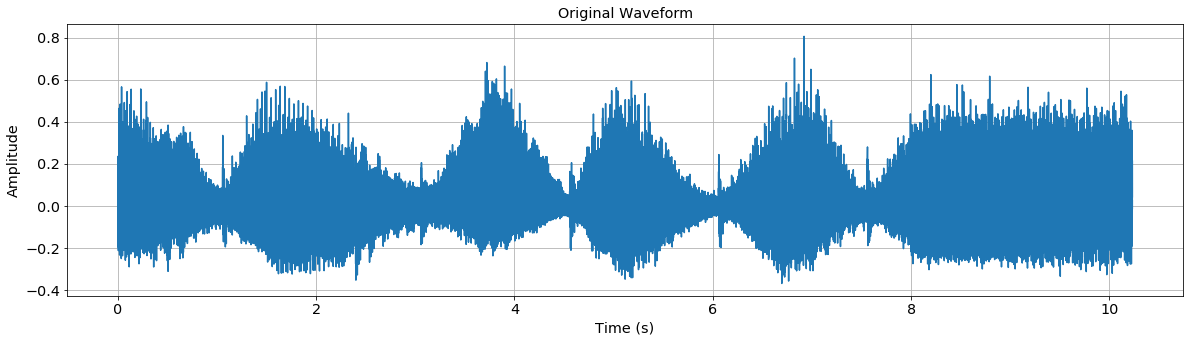

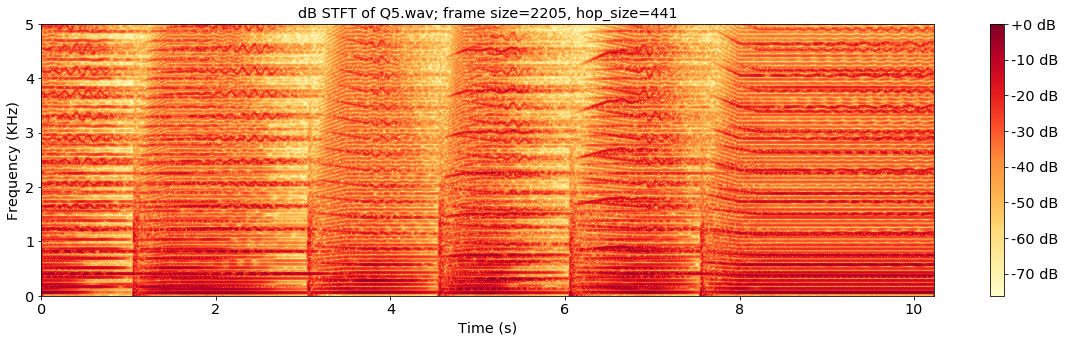

In [12]:
q5.printAttributes()
q5.plotWaveform()
q5_stft, q5_stft_dB, q5_freqs, q5_times = q5.STFT(q5.x_arr, plot=True)

# 1.2 

We are now going to locate in this sonogram "anchors", or points of interest. We will take a rather naive approach: for each continguous ΔTxΔF box, find the time and frequency with the largest energy. Let's make ΔT=100 ms, and ΔF be such that it divides the whole spectrum $[0,F_s/2]$ into 25 bands. For each one of these segments, locate the time and frequency of the largest value, as well as its dB. Do this for the sonogram you created in the last question.


In [8]:
q5_anch, q5_anch_mag = q5.getAnchors(q5_stft_dB, q5_freqs, q5_times, q5.sr, num_bands=25, dTime=0.100)

3.  With the anchors you found in the previous question, superimpose them on the sonogram. Write something intelligent about the results. My figure appears below, with each anchor marked by an "x".

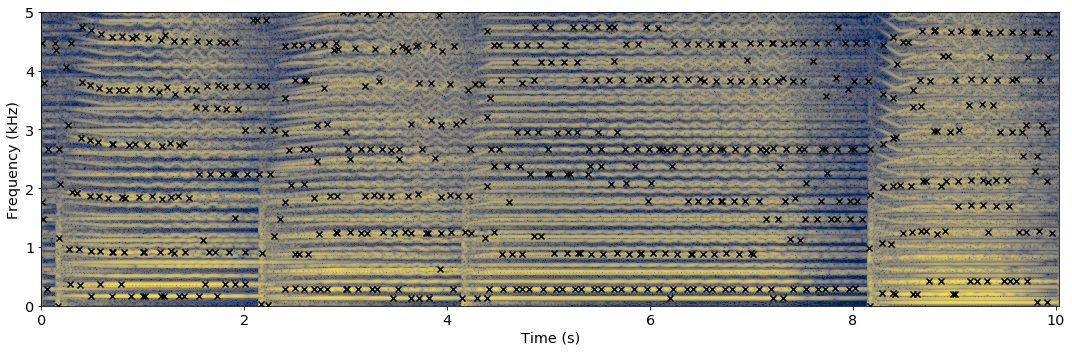

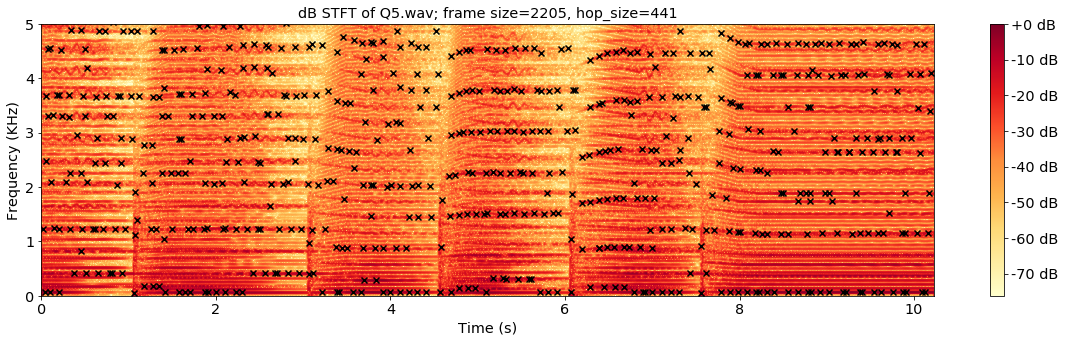

In [9]:
plt.figure()
plt.title('dB STFT of {}; frame size={}, hop_size={}'.format(q5.file_name, q5.frame_size, q5.hop_size))
plt.xlabel('Time (s)')
plt.xlim((0, q5.x.duration_seconds))
plt.ylabel('Frequency (KHz)')
plt.ylim((0, 5))
plt.pcolormesh(q5_times, q5_freqs / 1000, q5_stft_dB, cmap='YlOrRd')
plt.colorbar(format='%+2.0f dB')
plt.scatter(q5_anch[:, 1], q5_anch[:, 0] / 1000, marker='x', c='k')
plt.show()

**The anchors on the sonogram are located in the plotted areas that have the highest amount of energy. This is intuitively correct since the algorithm found the maximum values in smaller frequency and time frames; these points of interest on the audio file are of lower complexity than the original audio file and even lower than the STFT obtained from such file. This allows to have an adequate amount of information to search and compare.**

## 1.3

Now it's time to compute hashes from a set of anchors. A *hash* is a tuple describing an anchor at time ($t_1$) and its relationship to another anchor at time ($t_2$). A Shazam hash is the tuple $(f_1,f_2,∆t_{12})$, which contains the frequencies of both anchors ($f_1$,$f_2$), and the difference in their time positions ($∆t_{12} = t_2-t_1$). The Shazam fingerprint of an audio signal is then the set of hashes extracted from it as well as times at which each hash appears. To create these hashes, Shazam does not look at all pairs of anchors. For a given anchor, it computes hashes using anchors in a "target zone". Define the target zone of an anchor as a time-frequency region 100 ms after $t_1$, spanning 500 ms, and spanning frequencies one half-octave above and below $f_1$. For instance, for an anchor with $t_1$ and $f_1$, its target zone is located between $t_1+100$ ms and $t_1+100+500$ ms, and spans a frequency range of $f_12^{-0.5}$ and $f_12^{0.5}$. Compute all the hashes for your choosen query signal, in the form $(f_1,f_2,∆t_{12})$. Your final data structure representing a fingerprint $F$ should be something like a sequence of times paired with hashes $F = ((\tau_1, h_1), (\tau_2, h_2), \ldots)$, where $\tau_1$ is the time at which hash $h_1$ occurs, etc.

In [21]:
q5_fp = q5.getFingerprint(q5_anch)

In [31]:
print('Fingerprint times: \n')
print(q5_fp[:,0])

Fingerprint times: 

[0.04 0.1 0.37 ... 10.0 10.0 10.0]


In [32]:
print('Fingerprint hashes: \n')
print(q5_fp[:, 1])
print(q5_fp[:, 1][0])
print(q5_fp[:, 1][0][0])

Fingerprint hashes: 

[(70.0, 70.0, 0.16) (75.0, 70.0, 0.1) (415.0, 415.0, 0.14) ...
 (21170.0, 19405.0, 0.10999999999999943)
 (21170.0, 20290.0, 0.10999999999999943)
 (21170.0, 21170.0, 0.10999999999999943)]
(70.0, 70.0, 0.16)
70.0


# Part 2: Comparing fingerprints

## 2.1 

Now it's time to create an algorithm for comparing two fingerprints. We will start simple to make sure things work. Extract any 1-second segment of from the audiofile you worked with above and compute its fingerprint $F_q$ as above. ("q" is for "query".) Now for each hash in $F_q$, find all matching hashes in $F_q$, and store the times of the matches. To compare two hashes, compute the sum of the magnitude differences between the dimensions of the hashes. For instance, if I have these hashes, $(a,b,c)$ and $(d,e,f)$, I just compute the following value: $d = |(a-d)|+|(b-e)|+|(c-f)|$. If $d=0$ then it's a match! Create a scatter plot of the times of the matching hashes. Write something about what you see, and why you see it. Not why you see it, but *why* you see the properties you see in this particular plot. My plot looks like this: 

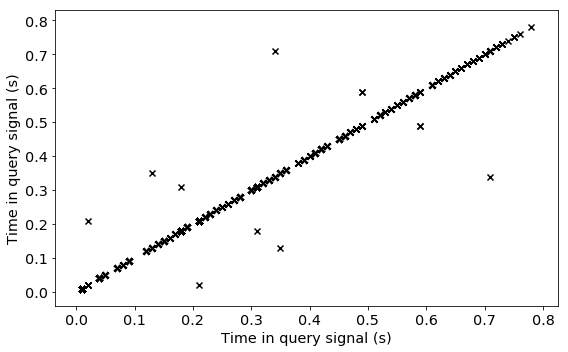



In [24]:
from tqdm import tqdm
import sys

def compareFingerprints(fp1, fp2):
    list_matches = []
    fp1_times = fp1[:, 0]
    fp2_times = fp2[:, 0]
    fp1_hashes = np.vstack(fp1[:, 1])
    fp2_hashes = np.vstack(fp2[:, 1])
    
    with tqdm(total=len(fp1_hashes), file=sys.stdout) as pbar:
#         for i, hash1 in enumerate(tqdm(fp1_hashes, desc='1st loop')):
        for i, hash1 in enumerate(fp1_hashes):
            pbar.set_description('Processed: %d' % (1 + i))
#             pbar.update(1)
            diff = np.sum(np.abs(hash1 - fp2_hashes), axis=1)
            match_idx = np.where(diff == 0)[0]

            if len(match_idx) > 0:
                for m in match_idx:
                    list_matches.append([fp1_times[i], fp2_times[m]])
                    
                    
            pbar.update(1)

    return np.array(list_matches)

In [27]:
_, q5_seg = q5.getSegment(start_time = 5.0, duration_sec = 1.0)
seg_stft, seg_stft_dB, seg_freqs, seg_times = q5.STFT(q5_seg, plot=False)
seg_anchors, seg_anchors_magnitudes = q5.getAnchors(seg_stft_dB, seg_freqs, seg_times, q5.sr, num_bands=25, dTime=0.100)
seg_fp = q5.getFingerprint(seg_anchors)

FqFq_matches = compareFingerprints(seg_fp, seg_fp)

Processed: 5166: 100%|██████████| 5166/5166 [00:09<00:00, 529.87it/s]


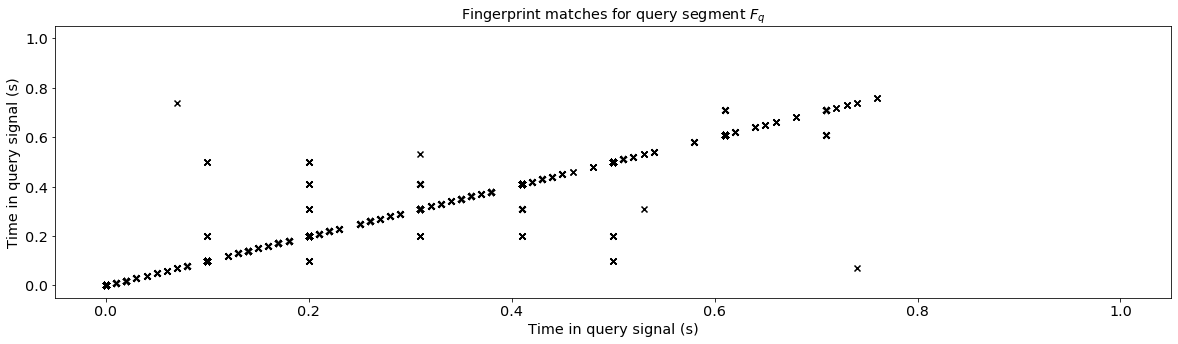

In [29]:
plt.title('Fingerprint matches for query segment ' + r'$F_q$')
plt.xlabel('Time in query signal (s)')
plt.ylabel('Time in query signal (s)')
plt.ylim((-0.05,1.05))
plt.xlim((-0.05,1.05))
plt.scatter(FqFq_matches[:, 0], FqFq_matches[:, 1], marker='x', color='k')
plt.show()

**The resulting comparison of the fingerprint with itself show that there is a linear match in the same time frames. For starters, this tells us that the algorithm is working properly: the compared hashes of the segment should be almost identical since the absolute value of the difference between hashes (frequencies of anchors and their respective time deltas) would ideally be zero for all segments. There are some outliers outside the main linear trend that are considered matches, this can be interpreted as hash similarities (similar frequencies for two anchors, with a similar time delta) that are present in other parts of the audio file. Redefining the target zone could potentially reduce this similarities, but would also increase computational costs.**

## 2.2 

Now compare $F_q$ with $F_d$, where $F_d$ is the fingerprint of the original audiofile. ("d" is for "document") Again make a scatter plot of the times of the matches. As above, write something about the results.

In [ ]:
FqFd_matches = compareFingerprints(q5_fp, seg_fp)

Processed: 90467: 100%|█████████▉| 90466/90537 [02:35<00:00, 634.75it/s]

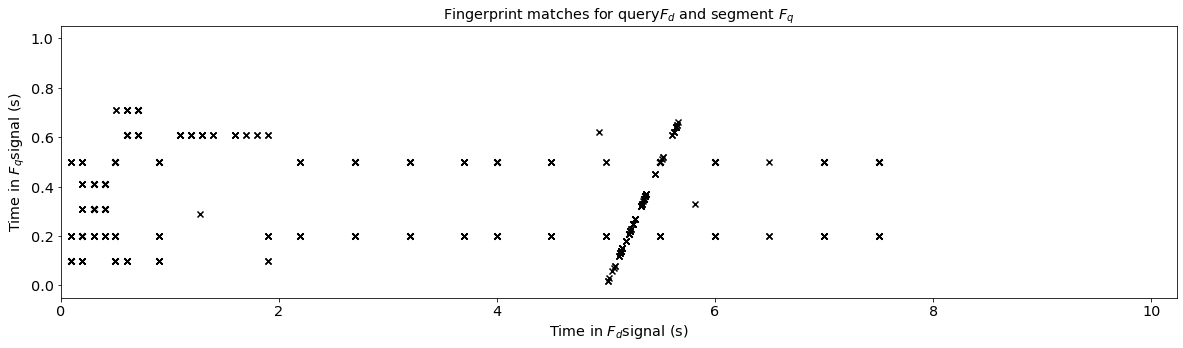

In [35]:
plt.title('Fingerprint matches for query' + r'$F_d$' + ' and segment ' + r'$F_q$')
plt.xlabel('Time in ' + r'$F_d$' + 'signal (s)')
plt.ylabel('Time in ' + r'$F_q$' + 'signal (s)')
plt.xlim((-0.05, q5.x.duration_seconds))
plt.ylim((-0.05, 1.05))
plt.scatter(FqFd_matches[:, 0], FqFd_matches[:, 1], marker='x', color='k')
plt.show()

** On a similar fashion, when comparing the fingerprints of the original file and of its own segment, a trendline can be found that show that there is an exact match for that particular section; the segment is made of 1 second taken at the 5s mark from the original file, so the trend appearing at t=5s in the x-axis tells that the algorithm is finding the correct matching patterns on the fingerprints. Similarities are found in other particular sections of the files, the interpration been that some of the anchors obtained from the STFT contain similar information in terms of frequencies and their respective time distances that repeat themselves in the original file.**

## 2.3 

Finally compare $F_q$ with $F_d$, where $F_d$ is the fingerprint of a *different* audiofile. Again make a scatter plot of the times of the matches. As above, write something about the results, and in particular compare with the plot produced in the l

Duration of sample sound:  10.03015873015873
Sample rate of sample sound in Hz:  44100
Number of channels:  1


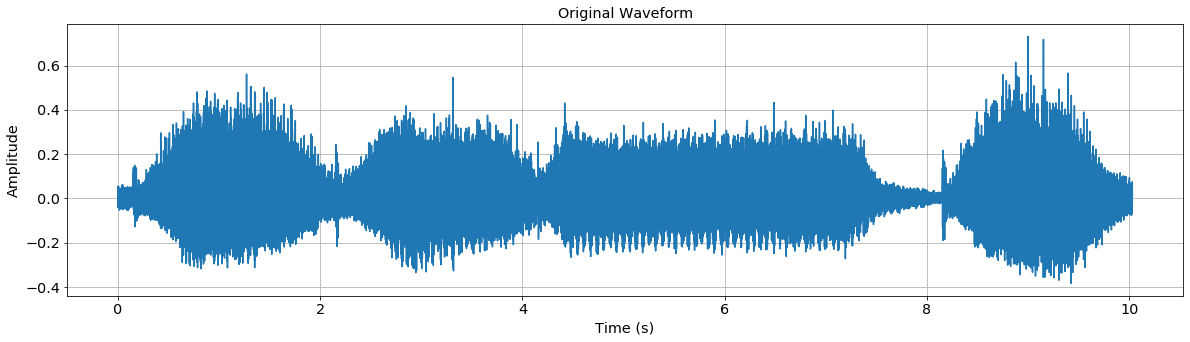

In [37]:
q1 = Query(folder=QUERIES, file_name='Q1.wav', frame_size_sec=0.050, hop_size_sec=0.010, zero_pad=4)
_, q1_stft_dB, q1_freqs, q1_times = q1.STFT(q1.x_arr, plot=False)
q1_anch, _ = q1.getAnchors(q1_stft_dB, q1_freqs, q1_times, q1.sr, num_bands=25, dTime=0.100)
q1_fp = q1.getFingerprint(q1_anch)
q1.printAttributes()
q1.plotWaveform()

In [40]:
q5q1_matches = compareFingerprints(q5_fp, q1_fp)

Processed: 90537: 100%|██████████| 90537/90537 [09:26<00:00, 159.77it/s]


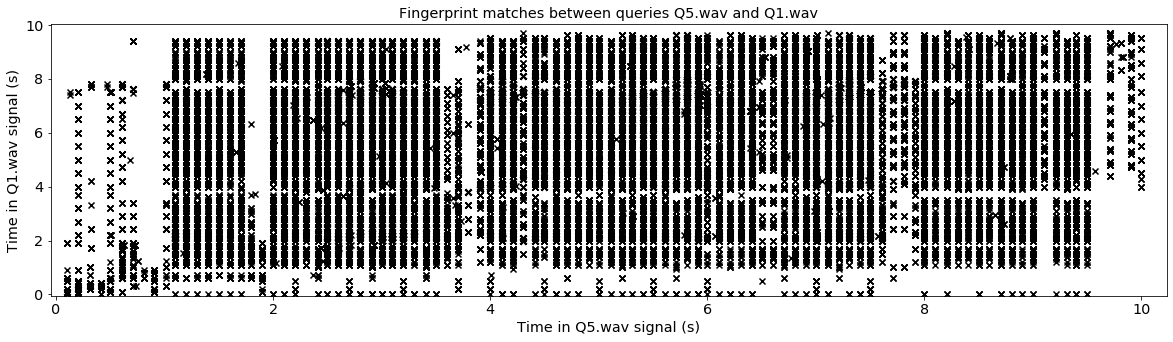

In [41]:
plt.title('Fingerprint matches between queries {} and {}'.format(q5.file_name, q1.file_name ))
plt.xlabel('Time in {} signal (s)'.format(q5.file_name))
plt.ylabel('Time in {} signal (s)'.format(q1.file_name))
plt.xlim((-0.05, q5.x.duration_seconds))
plt.ylim((-0.05, q1.x.duration_seconds))
plt.scatter(q5q1_matches[:, 0], q5q1_matches[:, 1], marker='x', color='k')
plt.show()

**The fingerprint comparison between queries 1 and 5 show that there are similarities between hashes that are present in Q1 and Q5. Without listening to the original files, one could suggest that the files are indeed different but the frequencies and time differences fore some anchors match repeatedly between queries, a probable cause being that a particular note was played by the same instrument in both files, although the constant spacing found for all Q5 at a particular Q1 time (i.e. the gap close to the 4s mark) means that there was a silence that was not present in Q5.**

# *2.4

Here's a project idea: Write a program to locate the files in the kiki-bouba collection from which all these queries come.